In [1]:
import os
import sys
import time
import csv
import cv2
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torchvision

import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn.functional as tfunc
from torch.utils.data import Dataset
from torch.utils.data.dataset import random_split
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as func
from PIL import Image

import sklearn.metrics as metrics
from scipy import misc
import random
from sklearn.metrics import roc_auc_score

In [11]:
print(torch.__version__)
print(torch.version.cuda)
gpu_availability = torch.cuda.is_available()
print(gpu_availability)
torch.cuda.empty_cache()

1.2.0+cu92
9.2.148
True


In [4]:
batch_size = 16
max_epoch = 3
class_count = 14    
class_names = ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 
               'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 
               'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']

train_path = 'CheXpert-v1.0-small/train.csv'
valid_path = 'CheXpert-v1.0-small/valid.csv'

In [106]:
class ChestXrayDataSet(Dataset):
    def __init__(self, image_list_file, transform=None):
        
        image_names = []
        labels = []
        with open(image_list_file, "r") as f:
            csvReader = csv.reader(f)
            next(csvReader, None)
            
            for line in csvReader:
                image_name= line[0]
                label = line[5:]
                label = self.processLabel(label)    
                image_names.append(image_name)
                labels.append(label)        
        
        self.image_names = image_names
        self.labels = labels
        self.transform = transform   
        
    def processLabel(self, label):
        for i in range(len(label)):
                    if label[i]:
                        a = float(label[i])
                        if a == 1:
                            label[i] = 1
                        elif a == -1:             
                            label[i] = 1        
                        else:
                            label[i] = 0
                    else:
                        label[i] = 0  
        return label

    def __getitem__(self, index):
    
        image_name = self.image_names[index]
        
#         if self.gray_scale:
#             image = Image.open(image_name).convert('L')
#         else:
#             image = Image.open(image_name).convert('RGB')
        
        image = Image.open(image_name)
        
        if self.transform is not None:
            image = self.transform(image)
        
        label = self.labels[index]
        return image, torch.FloatTensor(label)

    
    def __len__(self):
        return len(self.image_names)                              

In [115]:
#normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
# transformList = []
# transformList.append(transforms.RandomResizedCrop(320))
# transformList.append(transforms.RandomHorizontalFlip())
# transformList.append(transforms.ToTensor())
# transformList.append(normalize)      
# transformSequence=transforms.Compose(transformList)

img_crop = 224
# transformSequence = transforms.Compose([
#         transforms.Resize((img_crop,img_crop)),
#         transforms.ToTensor(),
#         #transforms.Normalize(mean=[0.5330], std=[0.0349]),
#         lambda x: x.expand(3,-1,-1),      
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])


transformSequence = transforms.Compose([
        transforms.Resize((img_crop,img_crop)),
        transforms.ToTensor(),
        #Mean and Variance of the CheXpert Dataset
        transforms.Normalize(mean=[0.5024], std=[0.2888]),
        lambda x: x.expand(3,-1,-1)])

In [119]:

dataset = ChestXrayDataSet(train_path, transformSequence)
datasetTest, datasetTrain = random_split(dataset, [5000, len(dataset) - 5000])
datasetValid = ChestXrayDataSet(valid_path, transformSequence)  

dataLoaderTrain = DataLoader(dataset=datasetTrain, batch_size=batch_size, shuffle=True,  num_workers=24, pin_memory=True)
dataLoaderVal = DataLoader(dataset=datasetValid, batch_size=batch_size, shuffle=False, num_workers=24, pin_memory=True)
dataLoaderTest = DataLoader(dataset=datasetTest, num_workers=24, pin_memory=True)


In [120]:
class CheXpertTrainer():

    def train (model, dataLoaderTrain, dataLoaderVal, class_count, trMaxEpoch, launchTimestamp, checkpoint):
        
        optimizer = optim.Adam (model.parameters(), lr=0.0001, betas=(0.9, 0.999), weight_decay=1e-5)
        loss = torch.nn.BCELoss(size_average = True)
        
        if checkpoint != None and gpu_availability:
            modelCheckpoint = torch.load(checkpoint)
            model.load_state_dict(modelCheckpoint['state_dict'])
            optimizer.load_state_dict(modelCheckpoint['optimizer'])

        lossMIN = 999
        for epochID in range(0, max_epoch):
            
            timestampTime = time.strftime("%H%M%S")
            timestampDate = time.strftime("%d%m%Y")
            timestampSTART = timestampDate + '-' + timestampTime
            
            losst, losse = CheXpertTrainer.epochTrain(model, dataLoaderTrain, optimizer, trMaxEpoch, class_count, loss)
            lossVal = CheXpertTrainer.epochVal(model, dataLoaderVal, optimizer, trMaxEpoch, class_count, loss)

            timestampTime = time.strftime("%H%M%S")
            timestampDate = time.strftime("%d%m%Y")
            timestampEND = timestampDate + '-' + timestampTime
            
            if lossVal < lossMIN:
                lossMIN = lossVal    
                #torch.save({'epoch': epochID + 1, 'state_dict': model.state_dict(), 'best_loss': lossMIN, 'optimizer' : optimizer.state_dict()}, 'm-epoch'+str(epochID)+'-' + launchTimestamp + '.pth.tar')
                print ('Epoch [' + str(epochID + 1) + '] [save] [' + timestampEND + '] loss= ' + str(lossVal))
            else:
                print ('Epoch [' + str(epochID + 1) + '] [----] [' + timestampEND + '] loss= ' + str(lossVal))
            
            torch.save({'epoch': epochID + 1, 'state_dict': model.state_dict(), 'best_loss': lossMIN, 'optimizer' : optimizer.state_dict()}, launchTimestamp +'-' + 'm-epoch'+str(epochID) +  '.pth.tar')
               
        return batchs, losst, losse        
       
    def epochTrain(model, dataLoader, optimizer, epochMax, class_count, loss):
        
        batch = []
        losstrain = []
        losseval = []
        
        model.train()

        for batchID, (varInput, target) in enumerate(dataLoaderTrain):
            
            varTarget = target.cuda(non_blocking = True)
            
            varOutput = model(varInput)
            lossvalue = loss(varOutput, varTarget)
                       
            optimizer.zero_grad()
            lossvalue.backward()
            optimizer.step()
            
            l = lossvalue.item()
            losstrain.append(l)
            
            if batchID%140==0:
                print(batchID//140, "% batches computed")
               
                loss_eval = CheXpertTrainer.epochVal(model, dataLoaderVal, optimizer, epochMax, class_count, loss).item()
                losseval.append(loss_eval)
                
                print("Batch ID", batchID)
                print("Train Loss", l)
                print("Eval Loss", loss_eval)
        return losstrain, losseval
    
    def epochVal(model, dataLoader, optimizer, epochMax, class_count, loss):
        
        model.eval()
        
        lossVal = 0
        lossValNorm = 0

        with torch.no_grad():
            for i, (varInput, target) in enumerate(dataLoaderVal):
                
                target = target.cuda(non_blocking = True)
                varOutput = model(varInput)
                losstensor = loss(varOutput, target)
                lossVal += losstensor
                lossValNorm += 1 
                
        outLoss = lossVal / lossValNorm
        return outLoss
    

    def computeAUROC (dataGT, dataPRED, classCount):
        
        outAUROC = []
        datanpGT = dataGT.cpu().numpy()
        datanpPRED = dataPRED.cpu().numpy()
        
        for i in range(classCount):
            try:
                outAUROC.append(roc_auc_score(datanpGT[:, i], datanpPRED[:, i]))
            except ValueError:
                pass
        return outAUROC
        

    def test(model, dataLoaderTest, nnClassCount, checkpoint, class_names):   
        
        cudnn.benchmark = True
        
        if checkpoint != None and gpu_availability:
            modelCheckpoint = torch.load(checkpoint)
            model.load_state_dict(modelCheckpoint['state_dict'])

        if gpu_availability:
            outGT = torch.FloatTensor().cuda()
            outPRED = torch.FloatTensor().cuda()
        else:
            outGT = torch.FloatTensor()
            outPRED = torch.FloatTensor()
       
        model.eval()
        
        with torch.no_grad():
            for i, (input, target) in enumerate(dataLoaderTest):

                target = target.cuda()
                outGT = torch.cat((outGT, target), 0).cuda()

                bs, c, h, w = input.size()
                varInput = input.view(-1, c, h, w)
            
                out = model(varInput)
                outPRED = torch.cat((outPRED, out), 0)
                
        print(outGT.size(), outPRED.size() )
                
        aurocIndividual = CheXpertTrainer.computeAUROC(outGT, outPRED, nnClassCount)
        aurocMean = np.array(aurocIndividual).mean()
        
        print ('AUROC mean ', aurocMean)
        
        for i in range (0, len(aurocIndividual)):
            print (class_names[i], ' ', aurocIndividual[i])
        
        return outGT, outPRED

In [8]:
class DenseNet121(nn.Module):

    def __init__(self, out_size):
        super(DenseNet121, self).__init__()
        self.densenet121 = torchvision.models.densenet121(pretrained=True)
        num_ftrs = self.densenet121.classifier.in_features
        self.densenet121.classifier = nn.Sequential(
            nn.Linear(num_ftrs, out_size),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.densenet121(x)
        return x


In [9]:
model = DenseNet121(class_count).cuda()
model = torch.nn.DataParallel(model).cuda()

In [121]:
timestampTime = time.strftime("%H%M%S")
timestampDate = time.strftime("%d%m%Y")
timestampLaunch = timestampDate + '-' + timestampTime

batch, losst, losse = CheXpertTrainer.train(model, dataLoaderTrain, dataLoaderVal, class_count, max_epoch, timestampLaunch, checkpoint = None)
print("Model trained")

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


0 % batches computed
Batch ID 0
Train Loss 0.2853502035140991
Eval Loss 0.3284032940864563
1 % batches computed
Batch ID 140
Train Loss 0.3431975543498993
Eval Loss 0.3403233587741852
2 % batches computed
Batch ID 280
Train Loss 0.3071175515651703
Eval Loss 0.3447626233100891
3 % batches computed
Batch ID 420
Train Loss 0.34587812423706055
Eval Loss 0.3389960527420044
4 % batches computed
Batch ID 560
Train Loss 0.3297862410545349
Eval Loss 0.3480137586593628
5 % batches computed
Batch ID 700
Train Loss 0.38997939229011536
Eval Loss 0.3289864659309387
6 % batches computed
Batch ID 840
Train Loss 0.2703259587287903
Eval Loss 0.3564981520175934
7 % batches computed
Batch ID 980
Train Loss 0.35456132888793945
Eval Loss 0.33249160647392273
8 % batches computed
Batch ID 1120
Train Loss 0.3016691207885742
Eval Loss 0.3473729193210602
9 % batches computed
Batch ID 1260
Train Loss 0.2778971493244171
Eval Loss 0.36130571365356445
10 % batches computed
Batch ID 1400
Train Loss 0.342702716588974


86 % batches computed
Batch ID 12040
Train Loss 0.3372778594493866
Eval Loss 0.3224693238735199
87 % batches computed
Batch ID 12180
Train Loss 0.3204899728298187
Eval Loss 0.35038644075393677
88 % batches computed
Batch ID 12320
Train Loss 0.2935267388820648
Eval Loss 0.3411104083061218
89 % batches computed
Batch ID 12460
Train Loss 0.29580679535865784
Eval Loss 0.34530943632125854
90 % batches computed
Batch ID 12600
Train Loss 0.4347723424434662
Eval Loss 0.3348865807056427
91 % batches computed
Batch ID 12740
Train Loss 0.31837108731269836
Eval Loss 0.3443700075149536
92 % batches computed
Batch ID 12880
Train Loss 0.3341537117958069
Eval Loss 0.341202050447464
93 % batches computed
Batch ID 13020
Train Loss 0.3805168569087982
Eval Loss 0.3503507673740387
94 % batches computed
Batch ID 13160
Train Loss 0.34987711906433105
Eval Loss 0.349044531583786
95 % batches computed
Batch ID 13300
Train Loss 0.32982850074768066
Eval Loss 0.3335970938205719
96 % batches computed
Batch ID 13440

73 % batches computed
Batch ID 10220
Train Loss 0.35551032423973083
Eval Loss 0.3584287166595459
74 % batches computed
Batch ID 10360
Train Loss 0.34580039978027344
Eval Loss 0.3453315198421478
75 % batches computed
Batch ID 10500
Train Loss 0.30703213810920715
Eval Loss 0.3465377986431122
76 % batches computed
Batch ID 10640
Train Loss 0.30112314224243164
Eval Loss 0.35090717673301697
77 % batches computed
Batch ID 10780
Train Loss 0.29434865713119507
Eval Loss 0.3504410982131958
78 % batches computed
Batch ID 10920
Train Loss 0.3032929003238678
Eval Loss 0.34340304136276245
79 % batches computed
Batch ID 11060
Train Loss 0.2838258743286133
Eval Loss 0.3342450261116028
80 % batches computed
Batch ID 11200
Train Loss 0.3119156062602997
Eval Loss 0.34255069494247437
81 % batches computed
Batch ID 11340
Train Loss 0.30998894572257996
Eval Loss 0.35848715901374817
82 % batches computed
Batch ID 11480
Train Loss 0.3777432441711426
Eval Loss 0.347486674785614
83 % batches computed
Batch ID 

60 % batches computed
Batch ID 8400
Train Loss 0.2724471688270569
Eval Loss 0.3478482961654663
61 % batches computed
Batch ID 8540
Train Loss 0.2754790186882019
Eval Loss 0.36199751496315
62 % batches computed
Batch ID 8680
Train Loss 0.323457807302475
Eval Loss 0.35055938363075256
63 % batches computed
Batch ID 8820
Train Loss 0.33568626642227173
Eval Loss 0.3385387063026428
64 % batches computed
Batch ID 8960
Train Loss 0.3697633743286133
Eval Loss 0.33401596546173096
65 % batches computed
Batch ID 9100
Train Loss 0.24383465945720673
Eval Loss 0.34661322832107544
66 % batches computed
Batch ID 9240
Train Loss 0.3443528711795807
Eval Loss 0.3394063711166382
67 % batches computed
Batch ID 9380
Train Loss 0.282325804233551
Eval Loss 0.34367474913597107
68 % batches computed
Batch ID 9520
Train Loss 0.29050731658935547
Eval Loss 0.3506649136543274
69 % batches computed
Batch ID 9660
Train Loss 0.30183878540992737
Eval Loss 0.3455388844013214
70 % batches computed
Batch ID 9800
Train Loss

In [122]:
, figsize=(6,3)outGT1, outPRED1 = CheXpertTrainer.test(model, dataLoaderTest, class_count, "04012020-102349-m-epoch2.pth.tar", class_names)

torch.Size([5000, 14]) torch.Size([5000, 14])
AUROC mean  0.8124967311884282
No Finding   0.9038564644607842
Enlarged Cardiomediastinum   0.6744412914293456
Cardiomegaly   0.8713721812244438
Lung Opacity   0.7472647261205614
Lung Lesion   0.8183645288382018
Edema   0.863602411196194
Consolidation   0.7152788086667458
Pneumonia   0.7795518126050774
Atelectasis   0.738677541668739
Pneumothorax   0.8720557666273636
Pleural Effusion   0.8968092030900431
Pleural Other   0.8014482941332313
Fracture   0.7916826061663759
Support Devices   0.9005486004108885


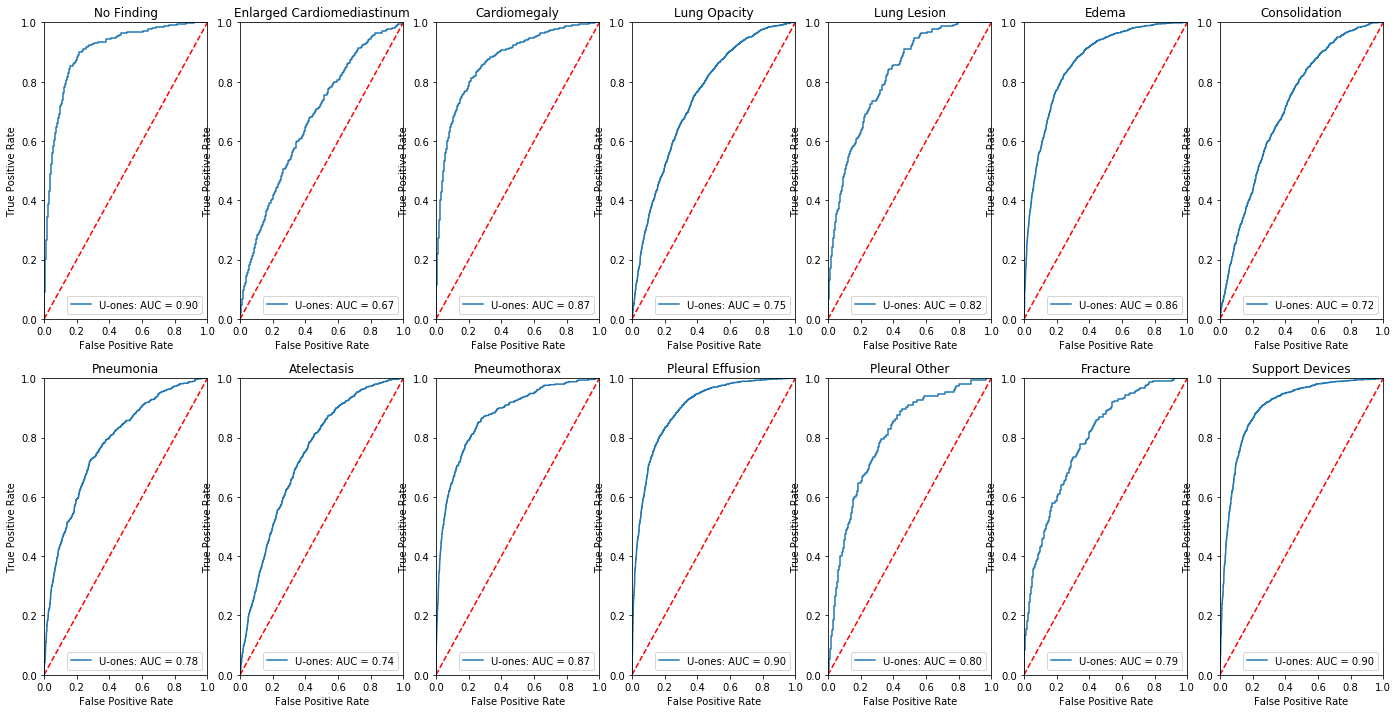

In [132]:
plt.figure(figsize=(24,12))

for i in range(class_count):
    fpr, tpr, threshold = metrics.roc_curve(outGT1.cpu()[:,i], outPRED1.cpu()[:,i])
    roc_auc = metrics.auc(fpr, tpr)
    f = plt.subplot(2, 7, i+1)
   
    plt.title(class_names[i])
    plt.plot(fpr, tpr, label = 'U-ones: AUC = %0.2f' % roc_auc)

    #plt.plot(fpr3, tpr3, label = 'AUC = %0.2f' % roc_auc3)

    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
# fig_size = plt.rcParams["figure.figsize"]
# fig_size[0] = 15
# fig_size[1] = 10
# plt.rcParams["figure.figsize"] = fig_size

#plt.savefig("ROC_509.png")
plt.show()

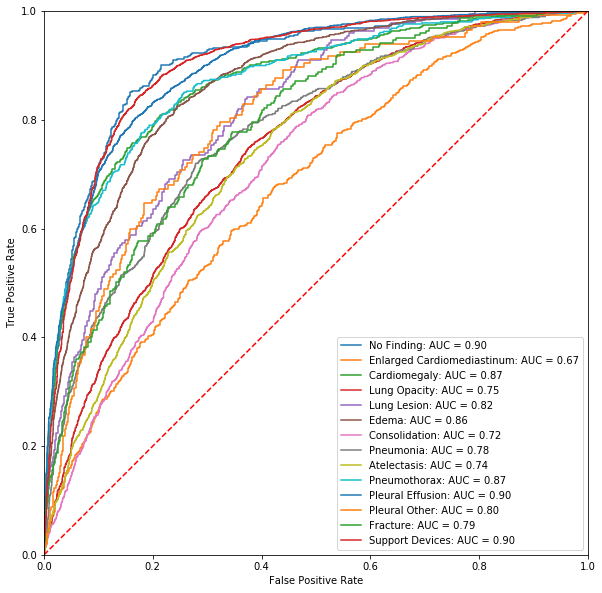

In [166]:
plt.figure(figsize=(12,10))

for i in range(class_count):
    fpr, tpr, threshold = metrics.roc_curve(outGT1.cpu()[:,i], outPRED1.cpu()[:,i])
    roc_auc = metrics.auc(fpr, tpr)
   
    #plt.title('ROC for: ' + class_names[i])
    plt.plot(fpr, tpr, label = class_names[i]+ ': AUC = %0.2f' % roc_auc)

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.gca().set_aspect('equal', adjustable='box')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.savefig("ROC_511.png")

In [20]:
class HeatmapGenerator ():
    
    def __init__ (self, pathModel, nnClassCount, transCrop):
       
        model = DenseNet121(nnClassCount).cuda()
    
        if gpu_availability:
            model = torch.nn.DataParallel(model).cuda()
        else:
            model = torch.nn.DataParallel(model)
        
        modelCheckpoint = torch.load(pathModel)
        model.load_state_dict(modelCheckpoint['state_dict'])
        self.model = model
        self.model.eval()
        
        self.weights = self.model.module.densenet121.classifier[0].weight
        print(self.model.module.densenet121.classifier[0])
        
        #print( self.weights)  
        
        self.transformSequence = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5024], std=[0.2888]),                                          
        lambda x: x.expand(3,-1,-1)])      
    
   
    def generate (self, pathImageFile, pathOutputFile, transCrop, labelss):
        
        with torch.no_grad():
 
            imageData = Image.open(pathImageFile).convert('L')
            imageData = self.transformSequence(imageData)
            imageData = imageData.unsqueeze_(0)
            if gpu_availability:
                imageData = imageData.cuda()
            l = self.model(imageData)
            output = self.model.module.densenet121.features(imageData)
            label = class_names[torch.max(l,1)[1]]
            weights = self.weights[torch.max(l,1)[1],:]
            
            print(l)
            print("Max Element", class_names[torch.max(l,1)[1]],   torch.max(l,1)[0].item())
            #print(output.shape)
        
            heatmap = None
            for i in range (0, len(weights[0])):
                feature_map = output[0,i,:,:]
                if i == 0: 
                    heatmap = weights[0,i] * feature_map
                else: 
                    heatmap += weights[0,i] * feature_map   
            npHeatmap = heatmap.cpu().data.numpy()
         
        imgOriginal = cv2.imread(pathImageFile, 1)
        imgOriginal = cv2.resize(imgOriginal, (transCrop, transCrop))
           
        cam = (npHeatmap-np.min(npHeatmap)) / (np.max(npHeatmap)-np.min(npHeatmap))
        cam = cv2.resize(cam, (transCrop, transCrop))
    
        heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
        
        strr=''
        for j in range(len(labelss)):
            if (labelss[j]==1):
                strr+=class_names[j]
                strr+= '\n'

        img = cv2.addWeighted(imgOriginal,1,heatmap,0.3,0)            
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.title("Predicted Label: %s"%label + "  %f " %torch.max(l,1)[0].item()  + "\nActual Label: %s" %strr )
        plt.imshow(img)
        plt.plot()
        plt.axis('off')
        
        

Linear(in_features=1024, out_features=14, bias=True)
15 [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1]
tensor([[0.0346, 0.0057, 0.0101, 0.6057, 0.0088, 0.2576, 0.1924, 0.0999, 0.3889,
         0.0381, 0.9099, 0.0021, 0.0058, 0.5266]], device='cuda:0')
Max Element Pleural Effusion 0.9098851680755615
53 [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
tensor([[0.0279, 0.0774, 0.0384, 0.3422, 0.8241, 0.0547, 0.1143, 0.1885, 0.0504,
         0.0152, 0.2189, 0.0409, 0.0314, 0.0515]], device='cuda:0')
Max Element Lung Lesion 0.8240995407104492
62 [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0]
tensor([[0.0280, 0.0695, 0.0147, 0.5438, 0.2401, 0.0109, 0.1016, 0.0263, 0.1703,
         0.7780, 0.3208, 0.0242, 0.0110, 0.7168]], device='cuda:0')
Max Element Pneumothorax 0.777960479259491


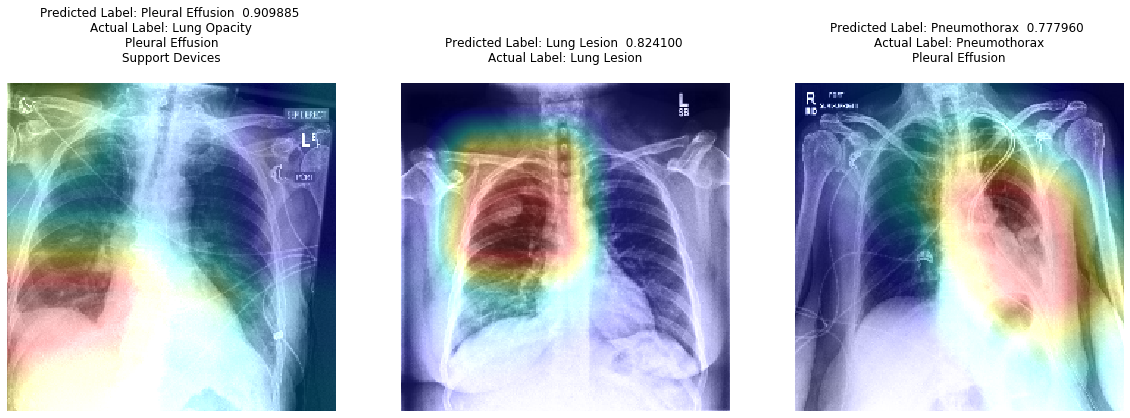

In [30]:
image_names = []
labels = []
counter = 0
with open(train_path, "r") as f:
    csvReader = csv.reader(f)
    next(csvReader, None)  
    for line in csvReader:
        image_name= line[0]
        label = line[5:]  
        for i in range(len(label)):
            if label[i]:
                a = float(label[i])
                if a == 1:
                    label[i] = 1
                elif a == -1:
                    label[i] = 1
                else:
                    label[i] = 0
            else:
                label[i] = 0   
        image_names.append(image_name)
        labels.append(label)
        counter += 1
        if counter==500:
            break


imgtransCrop = 224
pathModel = "04012020-102349-m-epoch2.pth.tar"
pathOutputImage = 'heatmap_view1_frontal.png'



h = HeatmapGenerator(pathModel, class_count , imgtransCrop)


counter=1
plt.figure(figsize=(20,10))
#Images Predicted with 3 different labels
for i in [14,52,61]:
    
    plt.subplot(1,3,counter)
    
    print(i+1, labels[i])
    h.generate(image_names[i],'heatmap_%d.png' %i, imgtransCrop, labels[i])
    counter += 1
#     for j in range(len(labels[i])):
#         if (labels[i][j]==1):
#             print("Actual Label:" , class_names[j])
plt.savefig("heatmaps.png")
plt.show()


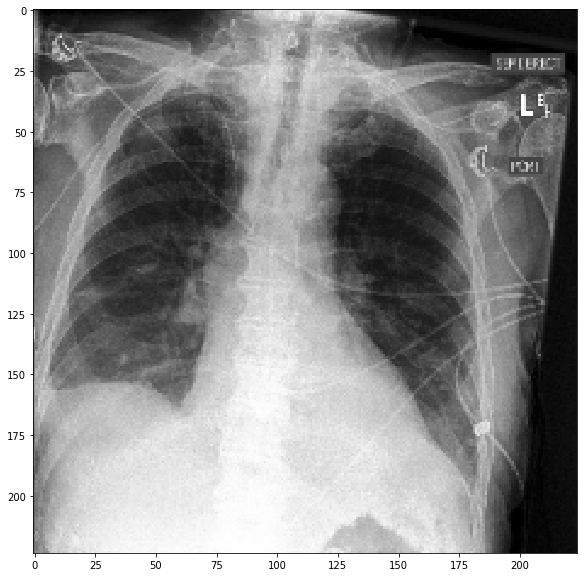

In [190]:
imgOriginal = cv2.imread(image_names[14], 1)
imgOriginal = cv2.resize(imgOriginal, (imgtransCrop, imgtransCrop))

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 10
plt.imshow(imgOriginal)

In [117]:
dataaa= ChestXrayDataSet(train_path, transforms.Compose([transforms.Resize((img_crop,img_crop)),transforms.ToTensor()]) )
dataLoaderT = DataLoader(dataset=dataaa, batch_size=1, shuffle=True,  num_workers=24, pin_memory=True)

In [95]:
m=0
st = 0
for batchID, (varInput, target) in enumerate(dataLoaderT):
    m = m+(varInput.mean()-m)/(batchID+1)
    st = st + (varInput.std()-st)/(batchID+1)
print( m, st)
    

tensor(0.5024) tensor(0.2888)


In [5]:
counter = 0
rad1 = [[0.05,0.48],[0.09,0.63],[0.11,0.66],[0.21,0.8],[0.05,0.82]]
rad2 = [[0.23,0.85],[0.19,0.79],[0.09,0.48],[0.18,0.71],[0.17,0.83]]
rad3 = [[0.11,0.7],[0.07, 0.58],[0.03,0.45],[0.31,0.92],[0.14,0.89]]

plt.figure(figsize=(24,5))
for i in [2,5,6,8,10]:
    fpr, tpr, threshold = metrics.roc_curve(outGT1.cpu()[:,i], outPRED1.cpu()[:,i])
    roc_auc = metrics.auc(fpr, tpr)
    f = plt.subplot(1, 5, counter+1)
   
    plt.title(class_names[i])
    plt.plot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc)

    plt.plot(rad1[counter][0], rad1[counter][1], marker='v', markersize=8, color="red", label='Rad1')
    plt.plot(rad2[counter][0], rad2[counter][1], marker='v', markersize=8, color="y", label='Rad2')
    plt.plot(rad3[counter][0], rad3[counter][1], marker='v', markersize=8, color="g", label='Rad3')
    #plt.plot(fpr3, tpr3, label = 'AUC = %0.2f' % roc_auc3)

    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    counter += 1
# fig_size = plt.rcParams["figure.figsize"]
# fig_size[0] = 15
# fig_size[1] = 10
# plt.rcParams["figure.figsize"] = fig_size

plt.savefig("ROC_510.jpg", dpi=200)
plt.show()

NameError: name 'outGT1' is not defined

<Figure size 1728x360 with 0 Axes>